# グローバル・ローカルアドレス割合

**日にち範囲指定をできるようにした改良版**


地点、日時によって、両者の割合がどのように異なるか、相関するかをチェックする。

 - アドレスごとに滞在時間（dwell_timedaily）を集計する前の<span class="burk">生のdailyデータからglobal/randomパケット数の変動をみる。</span>
 - dwell_timeから１時間単位で両者の個数をカウントしたhourly_countにおけるglobal/random割合の変動をチェックする。
 - 両者のデータを読み込む関数、描画する関数をひとまとめにpoint_dailyというクラスに書く
 
## point_dailyクラスの定義

 - コンストラクタ: area(地域), point(センサ), yearMonthDay(日時とデバイス名), 生データから抽出のための時間幅(分)をセット
 - readData(): 生データの読み込み
 - getHourlyDwellNum(): hourly_countフォルダにある集計データ（時間ごとのアドレス数）の読み込み
 - rec_aps(dwell_time_max, ext): dwell_timeデータから長時間滞在者を検出 dwell_time_max 時間, ext "", "all", "mon"のどれか

付録：
getPointName(area) ... area = kofu, hakushu or fuefuki  (デバイス名と地点名のリストを返す)


In [8]:
import matplotlib
# matplotlib.use('Agg')   # バッチ処理用（ディスプレイに表示しない）
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import csv
import glob
import re
import os
import sys

plt.rcParams['font.family'] = 'IPAPGothic'  # 全体のフォントを設定


class point_daily:
    def __init__(self, area, point, sdate, edate, width=10): # 
        """
        年月日の範囲を(sdate,edate)で指定
        width: 時間間隔(分)
        """
        self.area = area
        self.point = point
        self.sdate = sdate
        self.edate = edate
        self.width = width
        self.permanent_term = [] # 常設端末のアドレスリスト (rec_aps()で作成)

    def readData(self, ext=""):
        """
        daily csvを読み込んで、パケット量をグローバル・ランダムごとに比較する
        width: 時間刻み (分)
        """
        self.num_dev_global = np.zeros(int(np.ceil(24 * 60 / self.width)))  # width(分)単位のボックス
        self.num_dev_random = np.zeros(int(np.ceil(24 * 60 / self.width)))
        
        dir_name = ("/home/raspimngr/csv/" + self.area + "/points/" + self.point +
                    "/daily/")
        # ファイル一覧を取得
        if ext == "":
            ext_str = "[0-9]"
        else:
            ext_str = "[0-9]_" + ext
        files = glob.glob(dir_name + "*" + ext_str + ".csv")
        files.sort()
        
        for file in files:
            dateStr = re.split('[_.]', file.split('/')[-1])[0]
            if dateStr < self.sdate or dateStr > self.edate:
                continue
            # print(file)
            if not os.path.exists(file):
                print("cannot open file " + file)
                continue
            with open(file, 'r') as f:
                reader = csv.reader(f)
                header = next(reader)
                for line in reader:
                    # 時刻 (width(分)単位)
                    rec_t = dt.fromtimestamp(float(line[0]))
                    n_box = int((int(rec_t.strftime("%H")) * 60 +
                                 int(rec_t.strftime("%M"))) / self.width)
                    if int(line[5]) == 0:
                        self.num_dev_global[n_box] += 1
                    else:
                        self.num_dev_random[n_box] += 1
        self.global_ratio = (self.num_dev_global /
                             (self.num_dev_global + self.num_dev_random))
        
    def readHourlyDwellNum(self, ext="", yearMonthDay=""):
        """
        hourly_count内のファイル名の命名がdailyのと異なっていることに対応する必要がある
        1日のデータを分析、yearMonthDayに年月日を入れる
        """
        if yearMonthDay != "":
            self.yearMonthDay = yearMonthDay
        if not "yearMonthDay" in locals():
            print("引数にyearMonthDayを指定してください。")
            sys.exit()
        
        if ext != "":
            tmp = self.yearMonthDay.split("_")
            dayStr = tmp[0] + "_" + ext
        else:
            dayStr = self.yearMonthDay

        filename = (
            "/home/raspimngr/csv/" + self.area + "/points/" + self.point +
            "/hourly_count/hourly_" + dayStr + "_" + self.point + ".csv")
        if not os.path.exists(filename):
            print("cannot open file " + filename)
            return 0
        self.hourlyCount = np.zeros((24, 2))
        # print(filename)
        with open(filename, 'r') as f:
            reader = csv.reader(f)
            for line in reader:
                self.hourlyCount[int(line[0])] = np.array((int(line[1]),
                                                           int(line[2])))

    def showAddrRatio(self):
        idx = [
            '%02d:%02d' % (int(d / 60), int(d % 60))
            for d in range(0, 24 * 60, self.width)
        ]
        for i in range(len(idx)):
            print(idx[i], self.global_ratio[i])

    def plot_gl_numbers(self, scale="fixed"):
        # 描画
        x = np.arange(len(self.num_dev_global))
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(121)
        ax1.set_xlabel('*' + str(self.width) + " min.", fontsize=18)
        ax1.set_title(getPointName(self.area)[self.point]
                      + " (" + self.sdate + "-" + self.edate + ")")
        ax1.plot(x, self.num_dev_global)
        ax1.plot(x, self.num_dev_random)
        ax1.legend(('global', 'random'))
        ax2 = fig.add_subplot(122)
        ax2.set_xlabel('*' + str(self.width) + " min.", fontsize=18)
        ax2.plot(x, self.global_ratio)
        ax2.legend(('global rate'))
        if scale=='fixed':
            ax2.set_ylim(0.0,1.0)
        plt.show()
        
    def rec_aps(self, dwell_time_max=12, ext=""):
        '''
        dwell_timeファイルから長時間観測アドレスを抽出
        アクセスポイントなどの常設端末などの検出（長時間滞在者も含むと思われる）
        dwellt_time_max: (hour)
        '''
        delta_t = int(dwell_time_max) * 3600 # 滞在時間（秒）
        
        dir_name = ("/home/raspimngr/csv/" + self.area + "/points/" + self.point +
                    "/dwell_time/")
        # ファイル一覧を取得
        if ext == "":
            ext_str = "[0-9]" + "_" + self.point
        else:
            ext_str = "[0-9]_" + ext + "_" + self.point
        print(ext_str)
        files = glob.glob(dir_name + "*" + ext_str + ".csv")
        files.sort()
        temp_list = []
        self.total_number = 0
        
        for file in files:
            dateStr = re.split('[_.]', file.split('/')[-1])[1]
            #print(dateStr)
            if dateStr < self.sdate or dateStr > self.edate:
                continue
            
            if not os.path.exists(file):
                print("cannot open file " + file)
                continue       
            with open(file, 'r') as f:
                #print(file)
                reader = csv.reader(f)
                for line in reader:
                    self.total_number += 1
                    if (line[5]=="0" and (float(line[3]) - float(line[2]) > delta_t
                        or int(line[1]) > 10)):
                        temp_list.append(line[0])
        self.permanent_term = sorted(set(temp_list))
        
def getPointName(area):
    filename = {"kofu": "/var/www/html/kofu/kofu_position.csv",
               "fuefuki": "/var/www/html/ff/sensor_points.csv",
               "hakushu": "/home/toyoki/public_html/hakushu/points_hakushu.csv"}
    pointName = {}    
    with open(filename[area],"r") as f:
        reader = csv.reader(f)
        header = next(reader)
        for line in reader:
            if len(line) < 3:
                continue
            pointName[line[0]] = line[3]
    return pointName

kofu_dir = "/home/raspimngr/csv/kofu/points/"
hakushu_dir = "/home/raspimngr/csv/hakushu/points/"
fuefuki_dir = "/home/raspimngr/csv/fuefuki/points/"

In [2]:
# 長時間観測された端末のアドレス抽出を行ってみる

d = point_daily("kofu", "kofu22", "20181001","20181007",width=60)
d.rec_aps(2, ext="all")

print(d.permanent_term)
print(str(len(d.permanent_term)) + " of " + str(d.total_number))

[0-9]_all_kofu22
['00:1b:c7:f9:92:83', '00:22:cf:fc:b7:84', '00:26:ab:60:3b:3f', '00:26:b6:f6:36:14', '00:80:92:51:52:ae', '10:44:00:a1:af:da', '14:99:e2:cb:3b:54', '1c:b9:c4:1d:b3:68', '1c:b9:c4:5d:b3:63', '2c:5b:b8:36:4d:e9', '2c:f0:ee:4f:43:5f', '30:10:e4:84:de:e5', '40:40:a7:e7:6b:39', '44:03:2c:8d:b9:cc', '48:d6:d5:0c:db:9e', '48:d6:d5:23:fc:a0', '5c:1d:d9:99:68:b2', '5c:f5:da:62:ba:d9', '5c:f5:da:6a:3f:69', '60:e3:ac:e6:75:ab', '60:e3:ac:e8:70:73', '64:db:43:67:bd:9c', '64:eb:8c:bd:ee:42', '64:eb:8c:f2:9e:b1', '68:07:15:90:55:01', '68:ab:1e:5c:58:7e', '78:3a:84:98:ed:e6', '78:fd:94:32:47:36', '80:e6:50:41:69:68', '88:19:08:53:ce:11', '88:19:08:8d:09:f5', '8c:29:37:cc:2b:f1', '90:b9:31:b1:b6:fa', '94:39:e5:c3:df:77', '9c:5c:f9:34:e5:0c', 'b0:fc:36:57:25:ad', 'b4:74:9f:a3:31:2a', 'bc:77:37:74:a2:c5', 'c0:9f:42:0a:d6:fd', 'c0:f8:da:3b:8b:57', 'c4:54:44:44:5a:99', 'c4:54:44:55:a1:5c', 'c4:7d:46:b2:1c:f1', 'c4:7d:46:ba:74:3c', 'c8:f6:50:8c:7a:95', 'cc:82:eb:46:f8:3b', 'cc:c7:60:60:e3:

## パケット数比較

各地点の日ごと(daily)の生データを読みこんで、グローバル・ローカルのパケット数を比較する。

### 笛吹

日中はほぼ15%くらいで推移

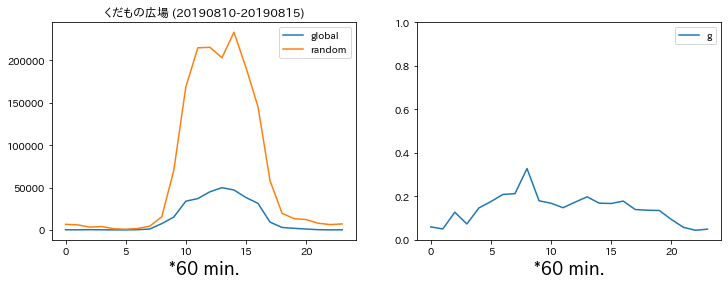

In [4]:
# dwell_dataを計算する前の生のデータ(daily)のパケット数比率
d = point_daily("fuefuki","ff08","20190810", "20190815", width=60)
d.readData("mon")
d.plot_gl_numbers()
#print(d.global_ratio)

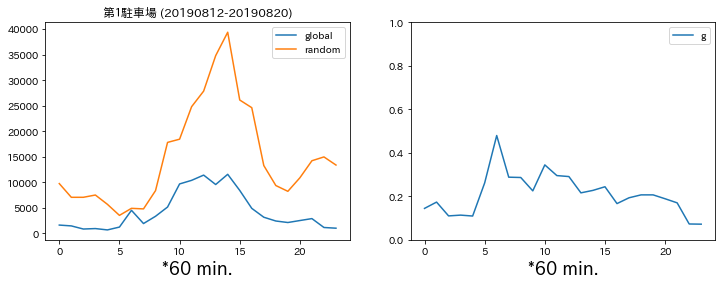

In [4]:
d = point_daily("fuefuki","ff07","20190812", "20190820", width=60)
d.readData("mon")
d.plot_gl_numbers()

### 甲府

地点による差が大きい。

AP、建物内設置の固定機器からのパケット、自動車カーナビなどからのパケットが多い可能性

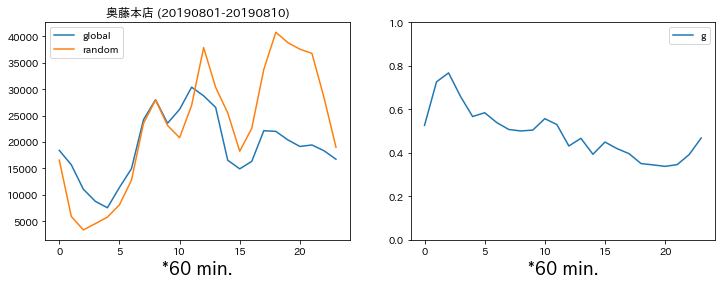

In [5]:
d = point_daily("kofu", "kofu22", "20190801","20190810",width=60)
d.readData()
d.plot_gl_numbers()

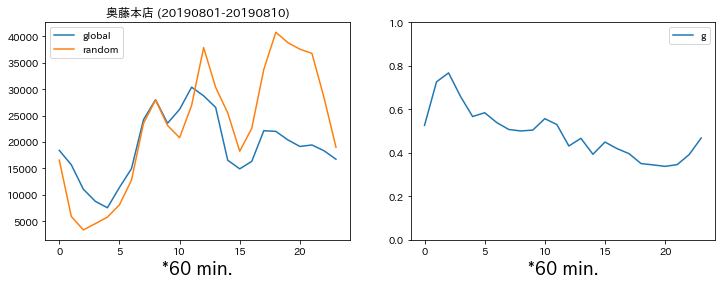

In [6]:
d = point_daily("kofu", "kofu22", "20190801","20190810",width=60)
d.readData()
d.plot_gl_numbers()

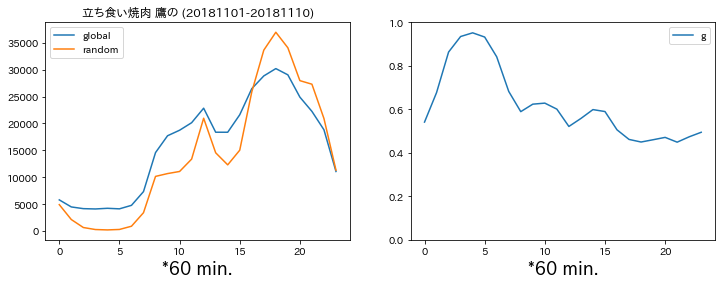

In [7]:
# 22 = 奥藤
d= point_daily("kofu", "kofu12", "20181101","20181110", width=60)
d.readData()
d.plot_gl_numbers()

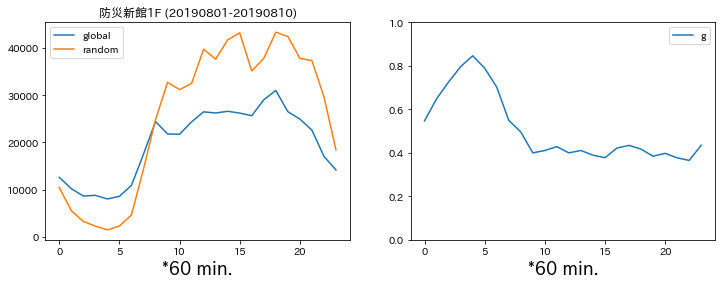

In [8]:
d = point_daily("kofu", "kofu9", "20190801", "20190810",60)
d.readData()
d.plot_gl_numbers()

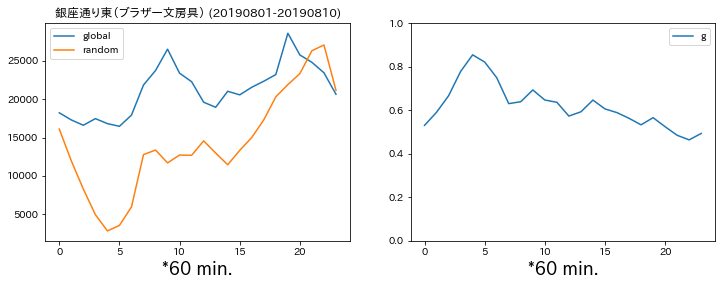

In [9]:
d = point_daily("kofu", "kofu13", "20190801","20190810",60)
d.readData()
d.plot_gl_numbers()

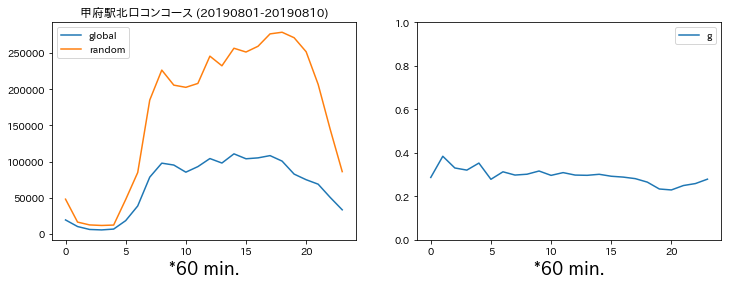

In [10]:
d = point_daily("kofu", "kofu27", "20190801", "20190810",60)
d.readData("mon")
d.plot_gl_numbers()

北口コンコースは20%～30%であり、笛吹の地点に比べて比率は高い。

夜間は少なくなるので常時稼働している家庭やオフィスのルータ等とは考えにくい。

車からのパケットの可能性がある。

南口は固定アドレスが24時間を通じてほぼ一定値である（固定局がある？）。⇒通行者はランダムのみの方がよく相関するだろう。

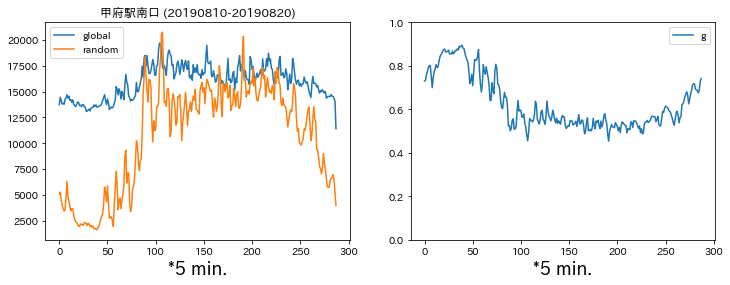

In [11]:
d = point_daily("kofu", "kofu25", "20190810","20190820",5)
d.readData("mon")
d.plot_gl_numbers()

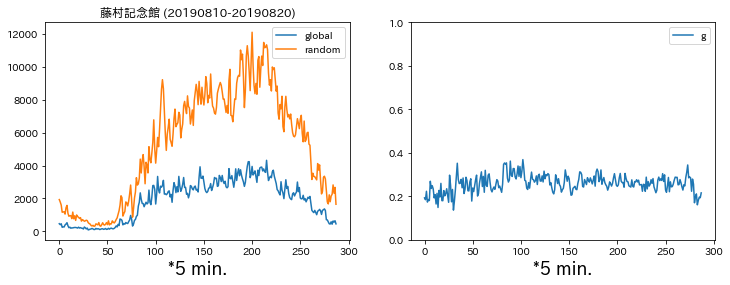

In [12]:
d = point_daily("kofu", "kofu26", "20190810","20190820",5)
d.readData("mon")
d.plot_gl_numbers()

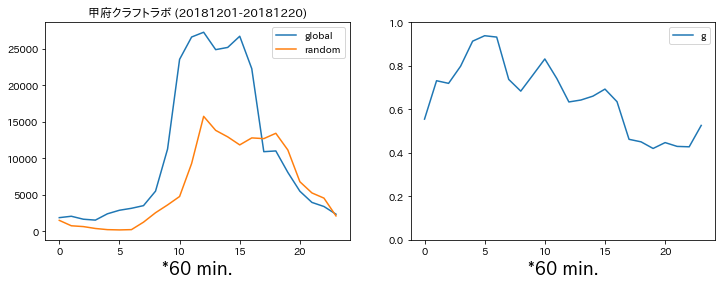

In [13]:
d = point_daily("kofu", "kofu16", "20181201","20181220",60)
d.readData()
d.plot_gl_numbers()

クラフトラボの振る舞いは特異だ。（？？？）

固定が多い時間帯は高齢者が優勢、ランダムは若者によるもの？

## hourly_countのデータからみたglobal/randomアドレスの比較

フルーツ公園のデータより


readHourlyDwellNum関数によりデータを読み込んでプロット

```python
readHourlyDwellNum(ext, day)  # extはall、monなど。dayは20191021のような日付
```

### 個別の地点表示

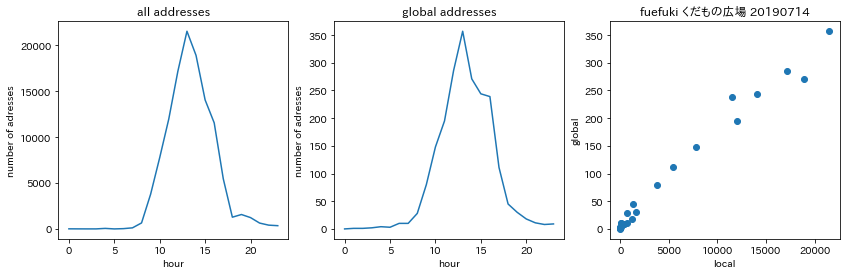

In [14]:
# dwell_timeから算出した時間ごとのアドレス数(hourly_count)のプロット
area = "fuefuki"
point = "ff08"
day = "20190714"
dev_str = "all"
a = point_daily(area, point, day, day, width=60)
# データの読み込み
a.readHourlyDwellNum(dev_str, day) # 2019年度以降に設置した箇所(kofu以外)はallが望ましい

# アドレス数の時間変化
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax1.plot(a.hourlyCount[:,0])
ax2 = fig.add_subplot(132)
ax2.plot(a.hourlyCount[:,1])
ax1.set_title("all addresses")
ax2.set_title("global addresses")
ax1.set_xlabel("hour")
ax1.set_ylabel("number of adresses")
ax2.set_xlabel("hour")
ax2.set_ylabel("number of adresses")

# global/localアドレス数の相関
ax3 = fig.add_subplot(133)
ax3.scatter(a.hourlyCount[:,0], a.hourlyCount[:,1])
ax3.set_title(area + " " + getPointName(area)[point] + " " + day)
ax3.set_xlabel("local")
ax3.set_ylabel("global")

plt.show()

### 複数地点のデータ表示

##### 笛吹フルーツ公園

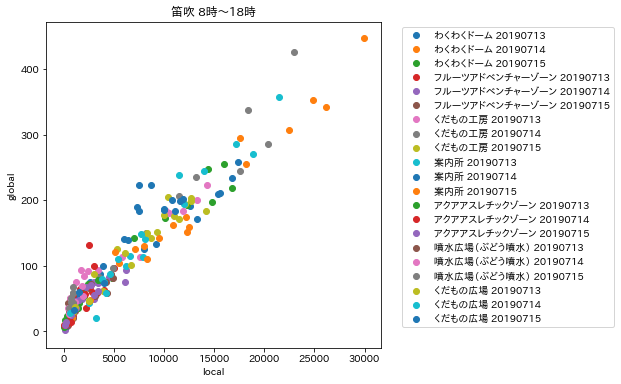

In [15]:
pointList = ["ff01", "ff02", "ff03", "ff04", "ff05", "ff06", "ff08"]
dayList = ["20190713", "20190714","20190715"]
# 時間範囲指定 [0:24]
sHour = 8
eHour = 18

dataList = {}
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

for p in pointList:
    dataList[p] = {}
    for d in dayList:
        dataList[p][d] = point_daily("fuefuki",p,d,d, width=60)
        dataList[p][d].readHourlyDwellNum("all", yearMonthDay=d)
        ax.scatter(dataList[p][d].hourlyCount[sHour:eHour, 0], dataList[p][d].hourlyCount[sHour:eHour, 1],
                   label=getPointName("fuefuki")[p] + " " + d)

ax.set_xlabel("local")
ax.set_ylabel("global")
ax.set_title("笛吹 " + str(sHour) + "時～" + str(eHour) + "時")
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### 甲府


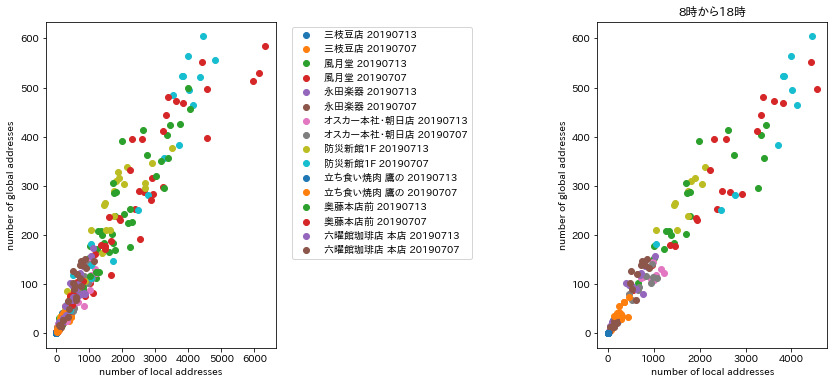

In [6]:
pointList = ["kofu2", "kofu3", "kofu4", "kofu8", "kofu9", "kofu12",  "kofu22", "kofu23"]
#pointList = ["kofu4", "kofu21", "kofu5"]
#pointList = ["kofu9", "kofu22", "kofu17","kofu12" ]
dayList = ["20190713","20190707"]
dataList = {}

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(133)
for p in pointList:
    dataList[p] = {}
    for d in dayList:
        dataList[p][d] = point_daily("kofu",p, d, d, width=60)
        dataList[p][d].readHourlyDwellNum("", d)
        ax.scatter(dataList[p][d].hourlyCount[:,0], dataList[p][d].hourlyCount[:,1],
                   label=getPointName("kofu")[p] + " " + d)
        ax1.scatter(dataList[p][d].hourlyCount[8:18,0], dataList[p][d].hourlyCount[8:18,1],
                   label=getPointName("kofu")[p] + " " + d) # 1列目の範囲指定により昼間のみ限定可能

ax.set_xlabel("number of local addresses")
ax.set_ylabel("number of global addresses")
ax1.set_xlabel("number of local addresses")
ax1.set_ylabel("number of global addresses")
ax1.set_title("8時から18時")
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend()
plt.show()

## 甲府市とフルーツ公園の比較

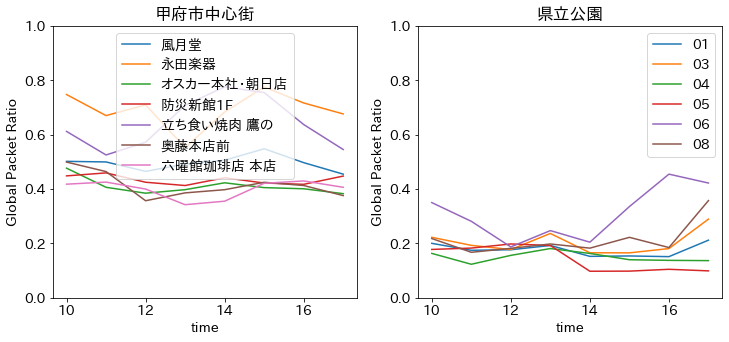

In [17]:
#地点ごとのアドレス数
pointList = [ "kofu3", "kofu4", "kofu8", "kofu9", "kofu12",  "kofu22", "kofu23"]
# 時間範囲指定 [0:24]
dataList = {}
fontsize=14
plt.rcParams.update({'font.size': fontsize})
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)

for p in pointList:
        dataList[p] = point_daily("kofu",p,"20190901","20190905", width=60)
        dataList[p].readData("")
        x = np.arange(len(dataList[p].num_dev_global[10:18]))
        ax.plot(range(10,18), dataList[p].global_ratio[10:18], label=getPointName("kofu")[p])
        # ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.legend()
        ax.set_ylim(0.0,1.0)
ax.set_xlabel("time")
ax.set_ylabel("Global Packet Ratio")
ax.set_title("甲府市中心街")

# 笛吹
#地点ごとのアドレス数
pointList = ["ff01","ff03","ff04","ff05","ff06","ff08"]
# 時間範囲指定 [0:24]
dataList = {}
ax1 = fig.add_subplot(122)

for p in pointList:
        dataList[p] = point_daily("fuefuki",p,"20190901","20190905", width=60)
        dataList[p].readData("mon")
        x = np.arange(len(dataList[p].num_dev_global[10:18]))
        ax1.plot(range(10,18), dataList[p].global_ratio[10:18], label=getPointName("fuefuki")[p])
        # ax1.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=8)
        ax1.legend()
        ax1.set_ylim(0.0,1.0)
ax1.set_xlabel("time")
ax1.set_ylabel("Global Packet Ratio")
ax1.set_title("県立公園")

import subprocess
filename_body = "gl_ratio_kofu_ff_20190901-0905"
plt.savefig(filename_body + '.svg', bbox_inches='tight')
subprocess.call('inkscape ' + filename_body + ".svg -M " + filename_body + ".emf", shell=True)
plt.show()

In [2]:
getPointName("kofu")
#getPointName("kofu")['kofu3']

{'kofu1': '',
 'kofu2': '三枝豆店',
 'kofu3': '風月堂',
 'kofu4': '永田楽器',
 'kofu5': '文化のるつぼ Hechima',
 'kofu6': '',
 'kofu7': 'ライフインナカゴミ',
 'kofu8': 'オスカー本社・朝日店',
 'kofu9': '防災新館1F',
 'kofu10': '河野スポーツ',
 'kofu11': '内藤セイビドー眼鏡店',
 'kofu12': '立ち食い焼肉 鷹の',
 'kofu13': 'ブラザー（文房具）',
 'kofu14': '甲州夢小路',
 'kofu15': '',
 'kofu16': '甲府クラフトラボ',
 'kofu17': 'ダン珈琲店',
 'kofu18': 'カフェ・キュイエール',
 'kofu19': 'きぬや',
 'kofu20': 'そば処 奥義',
 'kofu21': '玉屋',
 'kofu22': '奥藤本店',
 'kofu23': '六曜館珈琲店 本店',
 'kofu24': 'ルパンザバール ワイン酒場前',
 'kofu25': '甲府駅南口',
 'kofu26': '藤村記念館',
 'kofu27': '甲府駅北口コンコース',
 'kofu28': '甲府駅南口第１駐輪場',
 'kofu29': '甲府駅南口第２駐輪場'}

# Todo

多くの地点、日でのglobal/random相関係数、回帰係数の統計をとってみる

固定のAPなどの多さが地点の個性（特異性）になるだろうから、切片もいれる必要があるだろう。


In [18]:
# 連続処理用　ディレクトリ・ファイル一覧 (必要なくなった)
# area, 地点ID
import glob
import os

def getFileList(area, dev_str=""):
    # ディレクトリを検索しファイル一覧を取得する
    # dev_strはファイル名に含まれるデバイス名
    root_dir  = "/home/raspimngr/csv/" + area + "/points/"
    pointDirList = []
    fileList = []

    for point in os.listdir(root_dir):
        if os.path.isdir(root_dir + point):
            pointDirList.append(root_dir + point)
            for f in glob.glob(root_dir + point + "/hourly_count/*[0-9]"
                               + dev_str + "_" + point +".csv" ):
                fileList.append(f)
                
    return pointDirList, fileList

# テスト
pointList, fileList = getFileList("kofu")

# fileListから日にちと地点名を切り出す例
# dummy, day, pt = fileList[0].split("/")[-1].split("_")
# pt = pt.split(".")[0]
# print(pt)
# print(day)

def get_daily_count(area, point, day, dev_str=""):
    filename = ("/home/raspimngr/csv/" + area + "/points/"
                + point + "hourly_count/" + day + dev_str
                + "_" + point + ".csv")
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        

# データの読み込みと回帰係数の計算
import csv
for file in fiLeList:
    dummy, day, pt = fileList[0].split("/")[-1].split("_")
    point = pt.split(".")[0]
    with open(filename, 'r') as f:
            reader = csv.reader(f)
            header = next(reader)
            for line in reader:
                # 時刻 (width(分)単位)
                rec_t = dt.fromtimestamp(float(line[0]))
                n_box = int((int(rec_t.strftime("%H"))*60 +
                             int(rec_t.strftime("%M")))/width)
                if int(line[5]) == 0:
                    self.num_dev_global[n_box] += 1
                else:
                    self.num_dev_random[n_box] += 1        
    self.global_ratio = self.num_dev_global/(self.num_dev_global + self.num_dev_random)


kofu13
20190719
